# Optimization Study

- stop criteria: 

In [1]:
%config Completer.use_jedi = False

In [2]:
import math
import numpy as np
import pandas as pd
from cmaes import CMA
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist

## Objective Function

In [3]:
def errorfcn(alpha, Xbar, n, m):
    f1 = np.reshape(alpha[(2 * n):], (m, 2))
    f2 = np.reshape(alpha[0:2 * n], (2, n))
    f3 = Xbar[:, 0:n].T
    r = (Xbar - np.dot(f1, np.dot(f2, f3)).T) ** 2
    return np.nanmean(np.nanmean(r, axis=0))

In [4]:
import os

synthetic_datasets = os.listdir('datasets/sklearn-datasets')
real_datasets = os.listdir('datasets/real-datasets')

In [5]:
datasets_dictionary = dict()
# for f in synthetic_datasets:
#     try:
#         df = pd.read_csv(f'datasets/sklearn-datasets/{f}')
#         target_columns = [col for col in df.columns if col.startswith('target')]
#         datasets_dictionary[f] = (df, target_columns)
#     except:
#         pass

for f in real_datasets:
    try:
        df = pd.read_csv(f'datasets/real-datasets/{f}').drop(columns = ['instances'])
        target_columns = [col for col in df.columns if col.startswith('algo')]
        datasets_dictionary[f] = (df, target_columns)
    except:
        pass

In [6]:
df_teste = pd.read_csv('datasets/real-datasets/compas_metadata.csv').drop(columns = ['instances'])
performance_columns = [col for col in df_teste.columns if col.startswith('algo')]

In [7]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   feature_CL                5278 non-null   float64
 1   feature_CLD               5278 non-null   float64
 2   feature_DCP               5278 non-null   float64
 3   feature_F1                5278 non-null   float64
 4   feature_Harmfulness       5278 non-null   float64
 5   feature_N1                5278 non-null   float64
 6   feature_N2                5278 non-null   float64
 7   feature_TD_P              5278 non-null   float64
 8   feature_TD_U              5278 non-null   float64
 9   feature_kDN               5278 non-null   float64
 10  algo_bagging              5278 non-null   float64
 11  algo_gradient_boosting    5278 non-null   float64
 12  algo_logistic_regression  5278 non-null   float64
 13  algo_mlp                  5278 non-null   float64
 14  algo_ran

## IPOP-CMA-ES

In [8]:
from dataclasses import dataclass

@dataclass
class OptimizationOutput:
    A: np.ndarray
    B: np.ndarray
    C: np.ndarray
    Z: np.ndarray
    error: float
    execution_time: float
    n_tries: int
    search_space: float
    method_name: str

In [9]:
import time

def ipop_cma_es(X, Y, **kwargs):
    np.random.seed(0)
    
    Xbar = np.hstack((X, Y))
    n = X.shape[1]
    m = Xbar.shape[1]
    
    if 'search_space' not in kwargs:
        search_space = 32.768
    else:
        search_space = kwargs['search_space']
        
    bounds = list()
    bounds.append([[-search_space, search_space] for i in range(2 * m + 2 * n)])
    bounds = np.array(bounds).reshape((2 * m + 2 * n, 2))

    lower_bounds, upper_bounds = bounds[:, 0], bounds[:, 1]
    mean = lower_bounds + (np.random.rand(2 * m + 2 * n) * (upper_bounds - lower_bounds))
    sigma = search_space * 2 / 5  # 1/5 of the domain width

    optimizer = CMA(mean=mean, sigma=sigma, seed=0)
    
    if 'ntries' not in kwargs:
        ntries = 100
    else:
        ntries = kwargs['ntries']
        
    perf = np.zeros(ntries)
    alpha = np.zeros((2 * m + 2 * n, ntries))
    Hd = pdist(X)[np.newaxis].T
    
    start_time = time.time()
    for generation in range(ntries):
        solutions = []

        for _ in range(optimizer.population_size):
            # Sample parameters to evaluate function
            alpha[:, generation] = optimizer.ask()

            # Calculate function value
            value = errorfcn(alpha = alpha[:, generation], Xbar = Xbar, n = n, m = m)
            solutions.append((alpha[:, generation], value))
    #     print(f"#{generation} {value}")

        optimizer.tell(solutions)
    #     print('shape alpha', alpha.shape, "alpha\n", alpha)
        aux = alpha[:, [generation]]
        A = np.reshape(aux[0:2 * n], (2, n))
        Z = np.dot(X, A.T)
        perf[generation] = np.corrcoef(Hd, pdist(Z)[np.newaxis].T, rowvar=False)[0][1]

        # Restart
        if optimizer.should_stop():
            print('Optimizer should stop')
            # popsize multiplied by 2 (or 3) before each restart.
            popsize = optimizer.population_size * 2

            mean = lower_bounds + (np.random.rand(2 * m + 2 * n) * (upper_bounds - lower_bounds))
            optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize)
            print(f"Restart CMA-ES with popsize={popsize}")
    end_time = time.time()
    
    idx = np.argmax(perf)
    A = np.reshape(alpha[0:2 * n, idx], (2, n))
    Z = np.dot(X, A.T)
    B = np.reshape(alpha[(2 * n):, idx], (m, 2))
    Xhat = np.dot(Z, B.T)
    C = B[n:m + 1, :].T
    B = B[0:n + 1, :]
    error = np.sum((Xbar - Xhat) ** 2)
    
    execution_time = end_time - start_time
    out = OptimizationOutput(A, B, C, Z, error, execution_time, ntries, search_space, 'ipop')
    return out

In [10]:
from experimentation import run_optimization

In [11]:
%%time
ipop_output = run_optimization(df_teste, performance_columns, ipop_cma_es, ntries = 42, search_space = 1)

CPU times: user 18.8 s, sys: 3.81 s, total: 22.6 s
Wall time: 14 s


In [12]:
ipop_output.error

2579416041742.859

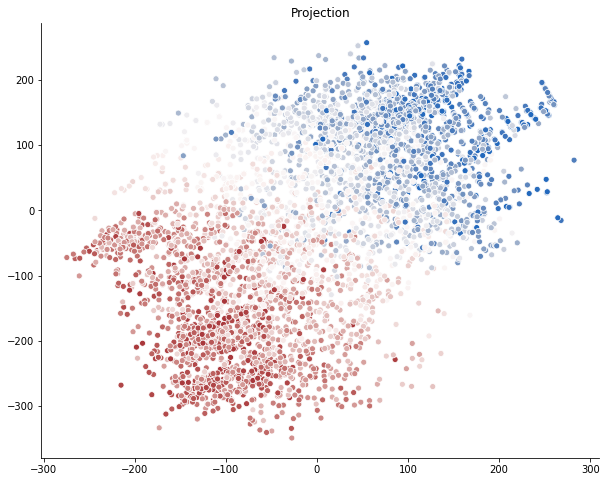

In [13]:
def plot_scatter_plot(x, y, title = None, x_label = None, y_label = None, hue_data = None):
    fig, ax = plt.subplots(figsize = (10, 8))
    n_colors = len(hue_data.unique())
    sns.scatterplot(x = x, y = y, hue = hue_data, palette = sns.color_palette("vlag", n_colors), legend = False)
    ax.set_title(title)
    sns.despine()
    
plot_scatter_plot(x = ipop_output.Z[:, 0], 
                  y = ipop_output.Z[:, 1], 
                  hue_data = df_teste.iloc[:,1],
                  title = "Projection")

In [14]:
%%time
experiments = dict()
for filename, item in datasets_dictionary.items():
    experiments[filename] = run_optimization(df = item[0], 
                                             target_columns = item[1], 
                                             optimization_method = ipop_cma_es, 
                                             ntries = 30, 
                                             search_space = 1)

CPU times: user 15.1 s, sys: 2.81 s, total: 17.9 s
Wall time: 10.5 s


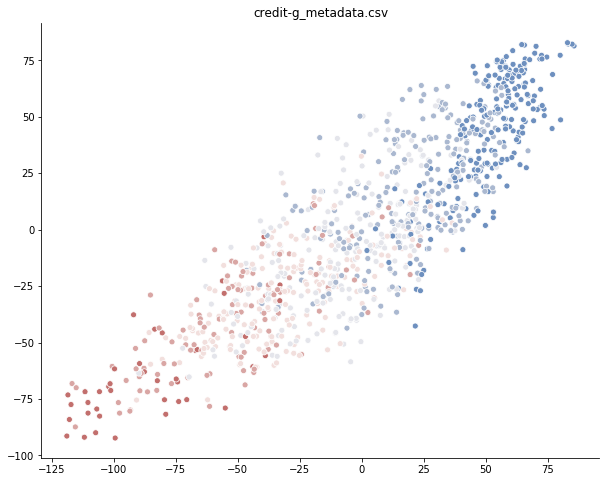

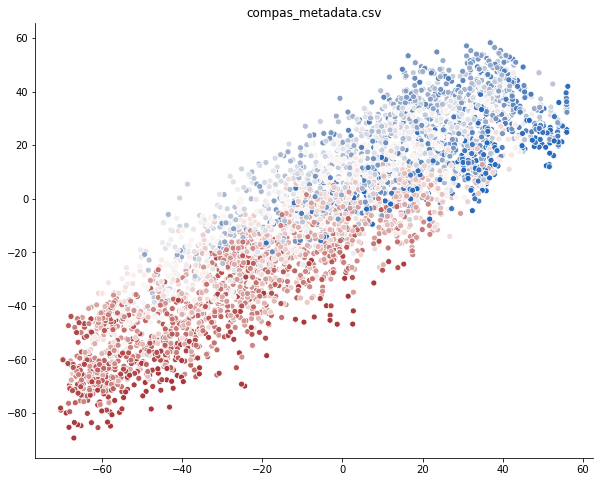

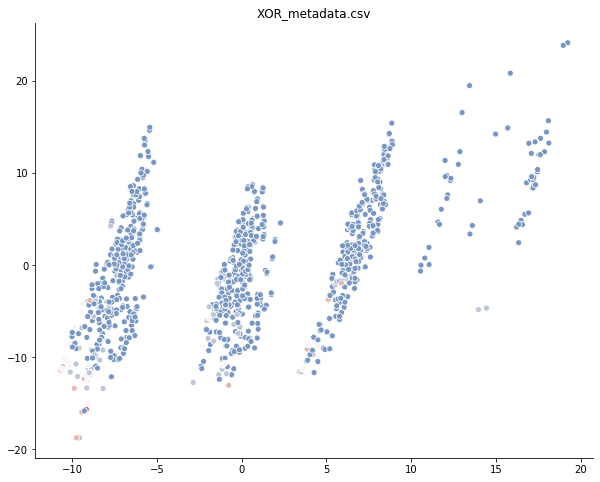

In [15]:
for dataset_filename in experiments.keys():
    plot_scatter_plot(x = experiments[dataset_filename].Z[:, 0],
                     y = experiments[dataset_filename].Z[:, 1],
                      hue_data = datasets_dictionary[dataset_filename][0].iloc[:, 0],
                     title = dataset_filename)

In [16]:
from experimentation import create_results_dataframe

ipop_results_df = create_results_dataframe(experiments)
ipop_results_df

,dataset,error,execution_time,method,n_tries,search_space
0,credit-g_metadata.csv,3.856458e+09,0.346231,ipop,30,1
1,compas_metadata.csv,1.192380e+10,9.464678,ipop,30,1
2,XOR_metadata.csv,8.315214e+06,0.357882,ipop,30,1


In [17]:
ipop_results_df.to_excel('results/ipop-results.xlsx')